# BioImageIT: experiment data processing

In this tutorial, we are going to write a pipeline for batch processing data stored in an `experiment`. **BioImageIT** API comes with a method called `run` that allows to sequancially exec tools on an data stored in an experiment.

## The experiment

In this tutorial, we will use the same experiment than the one created in the *tutorial1-experiment*. The experiment goal is explained in the *tutorial1*. As a reminder, we have two populations of images containing spots in noisy images. In this tutorial, we are going to segment and count the spots, and then run a statistical test to conclude if the two population have significantly different number of spots. 

In [1]:
# BioImageIT core import and initialisation
import bioimageit_core.api as iit

# initialize the BioImageIT request
req = iit.Request('../config.json')
req.connect()

In [3]:
# create experiment
experiment = req.create_experiment(name='tuto3_experiment',
                                   author='sprigent',
                                   date='now',
                                   destination="../workspace/")
# import the data
req.import_dir(experiment=experiment,
               dir_uri='./synthetic_data/data/',
               filter_=r'\.tif$',
               author='Sylvain Prigent',
               format_='imagetiff',
               date='now')
# annotate
req.annotate_from_name(experiment, "Population", ['population1', 'population2'] )
req.annotate_using_separator(experiment, key="number", separator="_", value_position=1)  
req.display_experiment(experiment)

--------------------
Experiment: 
	Name:  tuto3_experiment
	Author:  sprigent
	Created:  2022-02-23
	Key-value pairs: 
		- Population
		- number
	DataSet:  data
+---------------------+-------------+--------+-----------------+--------------+
|         Name        |  Population | number |      Author     | Created date |
+---------------------+-------------+--------+-----------------+--------------+
| population1_001.tif | population1 |  001   | Sylvain Prigent |  2022-02-23  |
| population1_015.tif | population1 |  015   | Sylvain Prigent |  2022-02-23  |
| population1_014.tif | population1 |  014   | Sylvain Prigent |  2022-02-23  |
| population1_016.tif | population1 |  016   | Sylvain Prigent |  2022-02-23  |
| population1_002.tif | population1 |  002   | Sylvain Prigent |  2022-02-23  |
| population1_003.tif | population1 |  003   | Sylvain Prigent |  2022-02-23  |
| population1_017.tif | population1 |  017   | Sylvain Prigent |  2022-02-23  |
| population1_013.tif | population1 |  

## The run() method

The **BioImageIT** run methods allows to execute a tool on an experiment. To this end we need to prepare a **job** object that contains all the information of the run. Let's look the **Job** documentation: 

In [4]:
from bioimageit_core.containers import Job

help(Job)

Help on class Job in module bioimageit_core.containers.runners_containers:

class Job(builtins.object)
 |  Container for a job information
 |  
 |  A job information lists all the needed information to run a tool on an experiment
 |  
 |  Attributes
 |  ----------
 |  experiment: Experiment
 |      Container of the experiment to process
 |  tool: Tool
 |      Tool to run
 |  parameters: dict
 |      Set of parameters that setup the tool.
 |  inputs: JobInputs
 |      Description of the job inputs in the database
 |  output_dataset_name: str
 |      Unique name of the output dataset
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  set_experiment(self, experiment)
 |  
 |  set_input(self, name, dataset, query, origin_output_name='')
 |  
 |  set_output_dataset_name(self, name)
 |  
 |  set_param(self, key, value)
 |  
 |  set_tool(self, tool)
 |  
 |  ----------------------------------------------------

We can see that a **Job** needs 3 main informations:
1. The experiment that will be processed
2. The tool that will be used
3. The query we will make on the experiment to specify the inputs. With the `set_input`method
4. The parameters of the the Tool

## Processing

In the following of this tutorial, we are going to process the data in 3 steps.
1. Image deconvolution on each image to ease the spot segmentation
2. Auto thresholding and particle analysis on the deblurred images
3. Statistical testing with the wilcoxon test to conclude if the two population have significantly different number of spots

The 3 proposed steps are just one possible way to analyse the data, to illustrate the use of BioImageIT. Many other processing workflow are possible to analyse this dataset, but it is not the purpose of this tutorial.

### Step 1: image deconvolution

To make the spot segmentation easier to identify, we chose to preprocess the data with a deconvolution algorithm. The selected algorithm is the Spitfire deconvolution implemented in c++. It is available in **BioImageIT** with the ID `spitfiredeconv2d_v0.1.2`. 

Lets create a **Job** to process all the images in the experiment with the spitfire deconv 2D tool.

In [5]:
# create the job
job = Job()
# set the experiment
job.set_experiment(experiment)
# set the tool
job.set_tool(req.get_tool('spitfiredeconv2d_v0.1.2'))
# query all the raw data for the spitfire input called 'i'
job.set_input(name='i', dataset='data', query='')
# set each parameters
job.set_param('sigma', '4')
job.set_param('regularization', '12')
job.set_param('weighting', '0.1')
job.set_param('method', 'SV')
job.set_param('padding', 'True')
# choose a name for the output dataset
job.set_output_dataset_name('deconv')

now we can run the job using the **BioImageIT** API

In [6]:
experiment = req.run(job)

  Start job1 
job 1:  simglib env already exists 
job 1:  Process population1_001.tif, progress: 0 
job 1:  Conda exec cmd: . "/Users/sprigent/BioimageIT/miniconda3/etc/profile.d/conda.sh" && conda activate simglib && "simgspitfiredeconv2d" "-i" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_001.tif" "-o" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif" "-sigma" "4" "-regularization" "12" "-weighting" "0.1" "-method" "SV" "-padding" "True" "-niter" "200" 
job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_001.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_002.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_002.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_007.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_007.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_010.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_010.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population2_002.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_002.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population2_015.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_015.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population2_011.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_011.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population2_006.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_006.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population2_009.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_009.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

job 1:  spitfire2d: input image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/data/population1_008.tif 
job 1:  spitfire2d: output image: /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_008.tif_o.tif 
job 1:  spitfire2d: method: SV 
job 1:  spitfire2d: regularization parameter: 12.000000 
job 1:  spitfire2d: weighting parameter: 0.100000 
job 1:  spitfire2d: nb iterations: 200 
job 1:  spitfire2d: use padding 
job 1:  Use 8 threads 
job 1:                                                                        | 0 % 
job 1:                                                                        | 10 % 
job 1:                                                                        | 20 % 
job 1:                                                                        | 30 % 
job 1:                                                                        | 40 % 
job 1:                                                                        | 

Let visualize the obtained results:

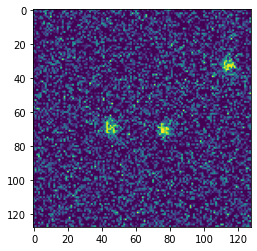

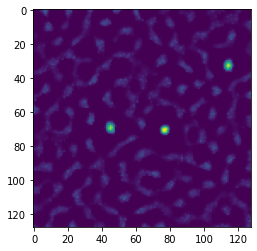

In [7]:
from skimage.io import imread
import matplotlib.pyplot as plt

# get the first deconvoluted image
processed_data = req.query(experiment, 'deconv', 'Population=population1 AND number=001')[0]
# get it origin raw data for visualisation
origin_data = req.get_origin(processed_data)

# plot the origin data
img=imread(origin_data.uri)
imgplot = plt.imshow(img)
plt.show()

# plot the processed data
img=imread(processed_data.uri)
imgplot = plt.imshow(img)
plt.show()

### Step 2: Image segmentation

In this step, we apply an automatique threshold and a particle analysis in each images in order to obtain the number of spots in each images.

The selected algorithm is a Fiji macro that runs an auto-threshold and the analyse particles tool. It is available in **BioImageIT** with the ID `threshold_particles_v1.0.0`. 

We can then run it the same way that the previous process:

In [8]:
# visualize the inputs and parameters of the svdeconv2d process
threshold_particles = req.get_tool('threshold_particles_v1.0.0')
threshold_particles.man()

Count particles : 
	          input	               	    Input image
	      threshold	   Default dark	Threshold method
	           draw	               	Particles drawing
	          count	               	Number of particles
	       measures	               	Particles measures


In [9]:
job2 = Job()
job2.set_experiment(experiment)
job2.set_tool(threshold_particles)
job2.set_input(name='input', dataset='deconv', query='')
job2.set_param('threshold', 'Minimum')
job2.set_output_dataset_name('particles')

experiment = req.run(job2)

  Start job2 
job 2:  threshold_particles env already exists 
job 2:  Process population1_001.tif_o, progress: 0 
job 2:  Conda exec cmd: . "/Users/sprigent/BioimageIT/miniconda3/etc/profile.d/conda.sh" && conda activate threshold_particles && "/Users/sprigent/BioImageIT/Fiji.app/Contents/MacOS/ImageJ-macosx" "--headless" "--console" "-macro" "threshold_particles.ijm" "[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_measures.csv]" 


[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_001.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_001.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_015.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_015.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_015.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_015.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_014.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_014.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_014.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_014.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_016.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_016.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_016.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_016.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_002.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_002.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_002.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_002.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_003.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_003.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_003.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_003.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_017.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_017.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_017.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_017.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_013.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_013.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_013.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_013.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_007.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_007.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_007.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_007.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_006.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_006.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_006.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_006.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_012.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_012.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_012.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_012.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_004.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_004.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_004.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_004.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_010.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_010.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_010.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_010.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_011.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_011.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_011.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_011.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_005.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_005.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_005.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_005.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_016.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_016.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_016.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_016.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_002.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_002.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_002.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_002.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_003.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_003.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_003.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_003.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_017.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_017.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_017.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_017.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_001.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_001.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_001.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_001.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_015.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_015.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_015.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_015.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_014.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_014.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_014.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_014.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_004.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_004.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_004.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_004.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_010.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_010.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_010.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_010.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_011.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_011.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_011.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_011.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_005.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_005.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_005.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_005.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_013.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_013.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_013.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_013.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_007.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_007.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_007.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_007.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_006.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_006.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_006.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_006.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_012.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_012.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_012.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_012.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_020.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_020.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_020.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_020.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_008.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_008.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_008.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_008.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_009.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_009.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_009.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_009.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_019.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_019.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_019.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_019.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_018.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_018.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population2_018.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population2_018.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_020.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_020.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_020.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_020.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_008.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_008.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_008.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_008.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_009.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_009.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_009.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_009.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_019.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_019.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_019.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_019.tif_o.tif 
job 2

[ERROR] Invalid service: sc.fiji.filamentdetector.gui.GUIStatusService
java.lang.NullPointerException
	at java.util.ArrayList.addAll(ArrayList.java:581)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:193)
	at org.scijava.util.ClassUtils.getAnnotatedFields(ClassUtils.java:163)
	at org.scijava.service.ServiceHelper.createServiceRecursively(ServiceHelper.java:315)
	at org.scijava.service.ServiceHelper.createExactService(ServiceHelper.java:267)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:229)
	at org.scijava.service.ServiceHelper.loadService(ServiceHelper.java:192)
	at org.scijava.service.ServiceHelper.loadServices(ServiceHelper.java:164)
	at org.scijava.Context.<init>(Context.java:278)
	at org.scijava.Context.<init>(Context.java:234)
	at org.scijava.Context.<init>(Context.java:174)
	at org.scijava.Context.<init>(Context.java:160)
	at net.imagej.ImageJ.<init>(ImageJ.java:77)
	at net.imagej.Main.main(Main.java:54)
	at sun.reflect.NativeMethodAcce

job 2:  parse args in args=[/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_018.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_measures.csv] 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_018.tif_o.tif,Minimum,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_draw.tif,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_count.csv,/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/particles/population1_018.tif_o_measures.csv 
job 2:  /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/deconv/population1_018.tif_o.tif 
job 2

The `threshold_particles` has 3 outputs: measure, draw and count. In this tutorial, we are interested in draw to visualize the detection results and count to get the number of detected spots for each image. Lets visualise it for one image:

the first image contains 3 particles


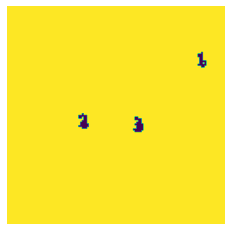

In [10]:
# query and print the count for the first image
count_data = req.query(experiment, 'particles', 'Population=population1 AND number=001', 'count')[0]
with open(count_data.uri, 'r') as file:
    print(f"the first image contains {file.read().rstrip()} particles")
          
# visualise the draw
draw_data = req.query(experiment, 'particles', 'Population=population1 AND number=001', 'draw')[0]
imgplot = plt.imshow(imread(draw_data.uri))
plt.axis('off')
plt.show()

### Step 3: Statistical test

In the previous step, the segmentation algorithm calulated the number of spots for each images. Then, we now need to perform a statistical test to measure if the spot number is statistically different for the two populations.

We will use the Wilcoxon test available in **BioImageIT**. 


In [11]:
wilcoxon_tool = req.get_tool('Wilcoxon_v1.0.0')
wilcoxon_tool.man()

Wilcoxon : 
	              x	               	   Population 1
	              y	               	   Population 2
	              t	               	              t
	              p	               	              p


In [12]:
job3 = Job()
job3.set_experiment(experiment)
job3.set_tool(wilcoxon_tool)
job3.set_input(name='x', dataset='particles', query='Population=population1', origin_output_name='count')
job3.set_input(name='y', dataset='particles', query='Population=population2', origin_output_name='count')
job3.set_output_dataset_name('wilcoxon')

experiment = req.run(job3)


  start, progress: 0 
  Start job3 
job 3:  scipy env already exists 
job 3:  Conda exec cmd: . "/Users/sprigent/BioimageIT/miniconda3/etc/profile.d/conda.sh" && conda activate scipy && "python3" "/Users/sprigent/Documents/bioimageit/toolboxes/tools/python-stats/wilcoxon.py" "-x" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/x.csv" "-y" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/y.csv" "-t" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/t.csv" "-p" "/Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/p.csv" 
job 3:  xfile /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/x.csv 
job 3:  yfile /Users/sprigent/Documents/bioimageit/workspace/tuto3_experiment/wilcoxon/y.csv 
job 3:  x: [3. 4. 4. 2. 4. 5. 2. 4. 5. 2. 4. 2. 3. 3. 4. 3. 4. 3. 2. 4.] 
job 3:  y: [4. 5. 6. 4. 5. 3. 3. 5. 4. 5. 6. 1. 4. 5. 5. 3. 5. 4. 6. 6.] 
job 3:  p value 0.004645864078986412 
job 3

/Users/sprigent/Documents/bioimageit/.env/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


With the code above, the Wilcoxon test has been performed between *population1* and *population2* using the result `count` of the job `particles`. 

Because the `Wilcoxon_v1.0.0` process works on merged data, we do not need to 'manualy' merge the results in an array files since **BioImageIT** do it for us.

Now we can read the results of the Wicoxon test:

In [13]:
wilcoxon_data = req.query(experiment, 'wilcoxon', 'name=p')[0]
print('processed data = ', wilcoxon_data.name )

with open(wilcoxon_data.uri, 'r') as content_file:
    p = content_file.read()    
print('p-value=', p)    

processed data =  p
p-value= 0.004645864078986412
